# Day high low and pivot fibonacci retracement - Analytics

### Import Library

In [8]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [9]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [10]:
data = dataset.copy()

In [11]:
data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-05-01 00:00:00')]

In [12]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2024-04-26 14:15:00,1229.9,1230.5,1227.3,1229.4,7567
2024-04-26 14:20:00,1229.8,1235.9,1229.4,1232.4,15934
2024-04-26 14:25:00,1232.5,1236.5,1232.1,1232.1,13075


In [13]:
day_data = data.resample('D').agg({
        'Open': 'first',
        'Close': 'last',
        'High': 'max',
        'Low': 'min',
        'Volume': 'sum'
    })
day_data.dropna(subset=['Close'], inplace=True)
day_data['prev_day_high'] = day_data['High'].shift(1)
day_data['prev_day_low'] = day_data['Low'].shift(1)
day_data["pivot"] = day_data.apply(lambda r: (r['High'] + r['Low'] + r['Close']) / 3, axis=1)
day_data['pivot'] = day_data['pivot'].shift(1)

In [14]:
def cal_high_position(row):
    return (row['High'] - row['pivot']) / (row['prev_day_high'] - row['prev_day_low'])

def cal_low_position(row):
    return (row['pivot'] - row['Low']) / (row['prev_day_high'] - row['prev_day_low'])
day_data['high_pos'] = day_data.apply(lambda row: cal_high_position(row), axis=1)
day_data['low_pos'] = day_data.apply(lambda row: cal_low_position(row), axis=1)

In [15]:
day_data

,Open,Close,High,Low,Volume,prev_day_high,prev_day_low,pivot,high_pos,low_pos
Date,,,,,,,,,,
2020-11-02,900.1,904.0,907.0,895.4,132589,NaN,NaN,NaN,NaN,NaN
2020-11-03,909.3,908.3,910.8,903.7,116107,907.0,895.4,902.133333,0.747126,-0.135057
2020-11-04,909.0,912.3,918.1,906.7,124814,910.8,903.7,907.600000,1.478873,0.126761
2020-11-05,913.7,910.2,919.9,910.0,130341,918.1,906.7,912.366667,0.660819,0.207602
2020-11-06,911.2,908.3,912.7,903.3,110492,919.9,910.0,913.366667,-0.067340,1.016835
...,...,...,...,...,...,...,...,...,...,...
2024-04-22,1200.0,1205.3,1215.3,1200.0,276424,1211.1,1191.7,1198.166667,0.883162,-0.094502
2024-04-23,1209.3,1200.6,1212.3,1188.6,304365,1215.3,1200.0,1206.866667,0.355120,1.193900
2024-04-24,1207.9,1230.5,1234.5,1207.1,297553,1212.3,1188.6,1200.500000,1.434599,-0.278481


In [16]:
day_data['high_pos_group'] = pd.qcut(day_data.high_pos, 30)
day_data['low_pos_group'] = pd.qcut(day_data.low_pos, 30)
day_data[['high_pos_group', 'low_pos_group']]

,high_pos_group,low_pos_group
Date,,
2020-11-02,NaN,NaN
2020-11-03,"(0.745, 0.814]","(-0.202, -0.123]"
2020-11-04,"(1.314, 1.49]","(0.105, 0.146]"
2020-11-05,"(0.629, 0.685]","(0.181, 0.235]"
2020-11-06,"(-0.102, -0.0119]","(0.951, 1.042]"
...,...,...
2024-04-22,"(0.879, 0.951]","(-0.123, -0.0822]"
2024-04-23,"(0.338, 0.379]","(1.136, 1.295]"
2024-04-24,"(1.314, 1.49]","(-0.346, -0.265]"


In [17]:
# Analytics

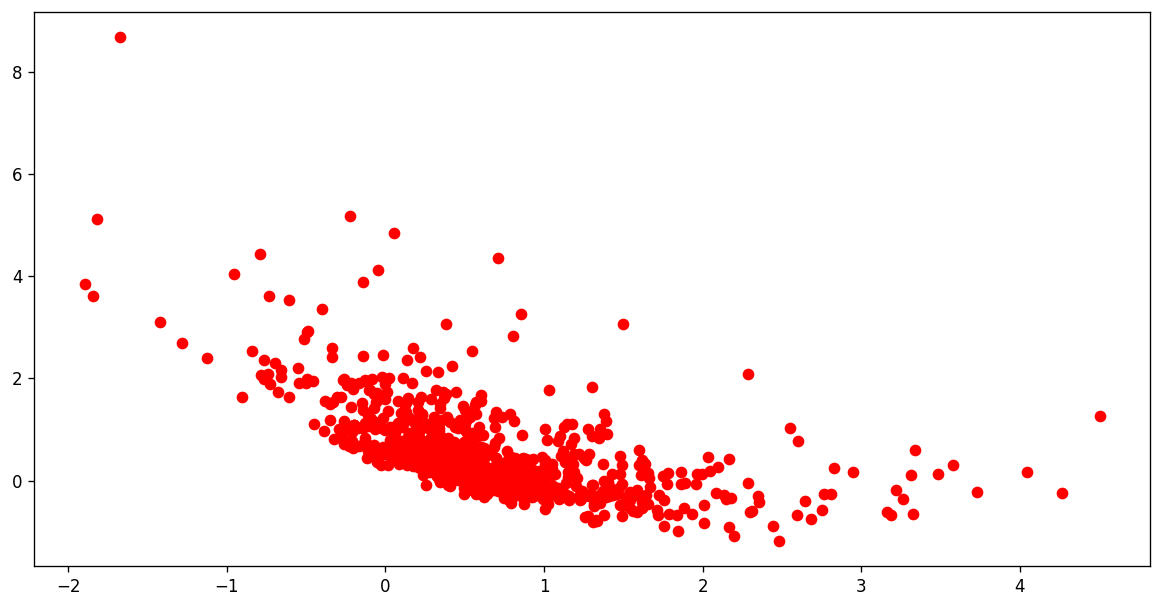

In [18]:
plt.scatter(day_data['high_pos'], day_data['low_pos'], c='red')

<Axes: xlabel='low_pos_group', ylabel='high_pos_group'>

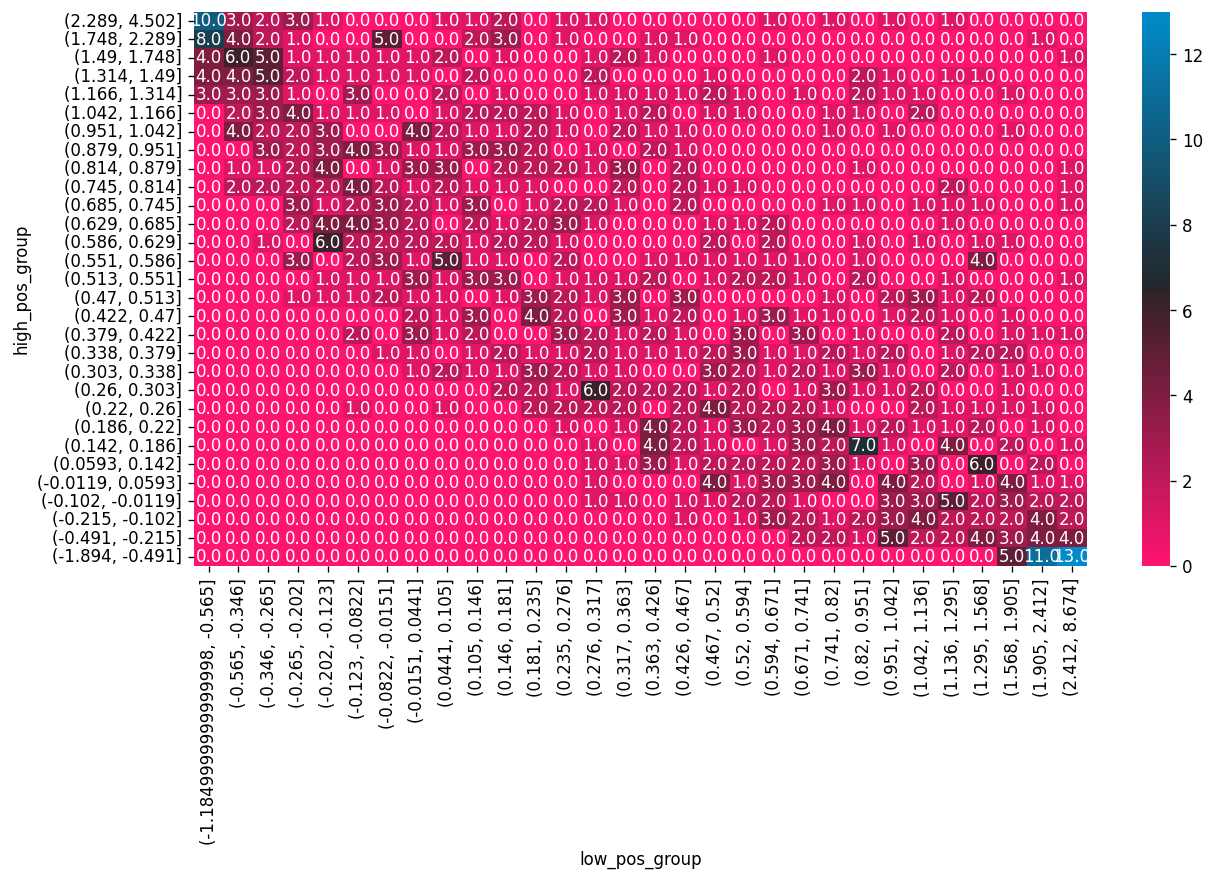

In [19]:
grpd = day_data.groupby(['high_pos_group', 'low_pos_group'])[['Volume']]
irs = grpd.count().reset_index()
sns.heatmap(
    irs.pivot(index='high_pos_group', columns='low_pos_group', values='Volume').sort_index(ascending=False),
    cmap=sns.diverging_palette(0, 240, s=100, l=55, center="dark", as_cmap=True),
    annot=True, fmt=".1f")